In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
import xgboost as xgb
from xgboost import plot_importance
import warnings

import time
import datetime
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"

In [2]:
dot_num1 = pd.read_csv(path + 'cst1.csv', header = None, names = ['order_date', 'dot', 'company', 'order_num'])
dot_num2 = pd.read_csv(path + 'cst2.csv', header = None, names = ['order_date', 'dot', 'company', 'order_num'])

In [3]:
dot_info = pd.read_csv(path + 'dot_1.csv', header = None, names = ['dot', 'check_date', 'dot_type', 'city_code', 'area', 'province', 'city', 'district', 'town', 'village'])

In [3]:
dot_num = pd.concat([dot_num1, dot_num2], ignore_index = True)
len(dot_num)
dot_num['order_date'] = [str(x)[0:4] +'-'+ str(x)[4:6] +'-'+ str(x)[6:] for x in dot_num['order_date']]
dot_num['order_date'] = pd.to_datetime(dot_num['order_date'])

14279441

In [58]:
dot_data_tmp = dot_num[dot_num['dot'].isin(dot_info['dot'])]

In [59]:
dot_data_tmp.head()

,order_date,dot,company,order_num
1,2017-09-19,甪直澄北点部,广州优之辰光,1
2,2017-02-28,龙岗碧岭点部,深圳嘉利铧鑫,1
11,2017-02-26,福田梅林点部,深圳晶明（上梅林）,1
12,2017-04-13,寮步东坑点部,东莞鼎立(寮步),1
13,2017-11-25,华强北燕南点部,北京前海润林,1


In [6]:
dot_data_tmp = dot_data_tmp.drop(['company'], axis = 1)

In [7]:
dot_groupby = dot_data_tmp.groupby(['dot', 'order_date']).sum()
dot_groupby.reset_index(inplace = True)

In [17]:
# a = dot_groupby.loc[dot_groupby['dot'] == '雨花大桥点部']

In [18]:
# a.index = a['order_date']

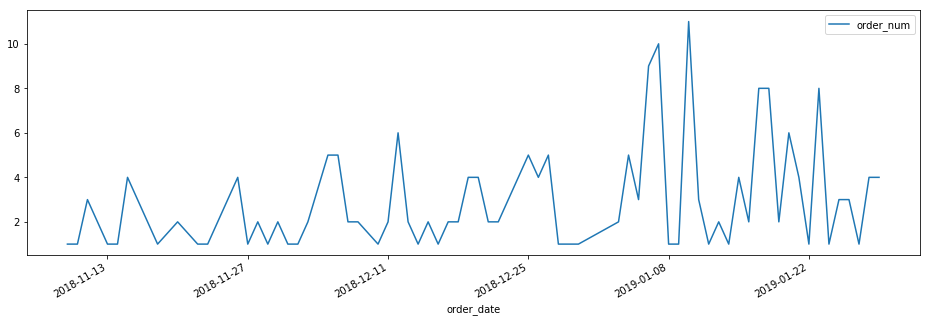

In [19]:
# a.loc[a['dot'] == '雨花大桥点部', ['order_num']].plot(figsize = (16,5))

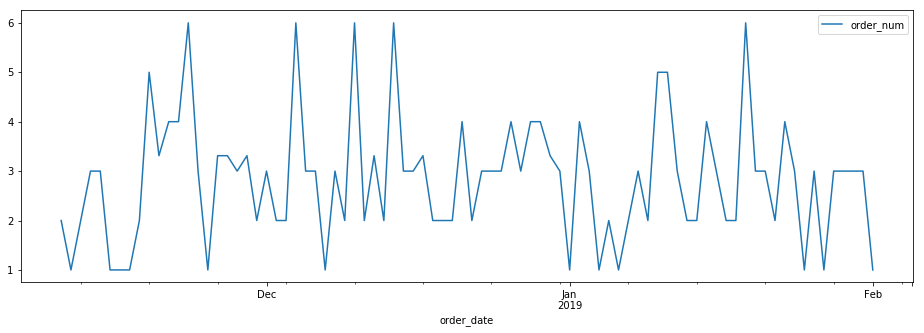

In [55]:
# b.loc[b['dot'] == '淄博贾村点部', ['order_num']].plot(figsize = (16,5))

In [53]:
# b = dot_preprocessing.loc[dot_preprocessing['dot'] == '淄博贾村点部']
# b.index = b['order_date']

In [20]:
dot_groupby.sort_values(by = 'order_date', inplace = True)
dot_groupby.head()

,dot,order_date,order_num
362815,桐乡凤鸣点部,2017-01-01,45
520924,珠海白蕉点部,2017-01-01,1
255774,常熟海虞点部,2017-01-01,1
436426,济南桑梓店点部,2017-01-01,26
354527,松江九亭点部,2017-01-01,7


In [21]:
dot_groupby.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752452 entries, 362815 to 600331
Data columns (total 3 columns):
dot           752452 non-null object
order_date    752452 non-null datetime64[ns]
order_num     752452 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 23.0+ MB


In [22]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(dot_groupby['dot'].unique()):
    one_dot = dot_groupby.loc[dot_groupby['dot'] == dot]
    check_time = dot_info.loc[dot_info['dot'] == dot, 'check_date']
    one_dot = one_dot[one_dot['order_date'] > check_time.iloc[0]]
    if len(one_dot) == 0:
        continue
    num_median = np.median(one_dot['order_num'])

    # 均值填充异常点
    lp = np.percentile(one_dot['order_num'],25)
    up = np.percentile(one_dot['order_num'],75)
    check_num = up + 1.5 * (up - lp)
    num_mean = np.mean(one_dot['order_num'])
    one_dot.loc[one_dot['order_num'] >= check_num, ['order_num']] = num_mean
    
    # 填充日期，中位数填充缺失值
    one_dot.index = one_dot['order_date']
    one_dot_resample = one_dot.resample('D').asfreq()
    one_dot_resample.drop(['order_date'], axis = 1, inplace = True)
    one_dot_resample.reset_index(inplace = True)
    one_dot_resample['dot'].fillna(dot, inplace = True)
    one_dot_resample['order_num'].fillna(num_median, inplace = True)
    one_dot_resample['dot_id'] = i + 1

    dot_preprocessing = pd.concat([dot_preprocessing, one_dot_resample], axis = 0,ignore_index = True)

In [23]:
dot_prep = dot_preprocessing.copy()
dot_prep['order_num'] = np.log1p(dot_prep['order_num'])
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.head()

,order_date,dot,order_num,dot_id
0,2017-01-14,桐乡凤鸣点部,4.077537,1
108416,2017-01-14,扬州槐泗点部,3.931826,181
107668,2017-01-14,青岛平度点部,1.386294,180
106918,2017-01-14,南昌高新点部,1.609438,179
106169,2017-01-14,长春二道点部,0.693147,178


In [24]:
dot_data = pd.merge(dot_info, dot_prep, how = 'left', on = 'dot')

In [25]:
dot_data.loc[dot_data['city'].isnull(), ['city']] = dot_data.loc[dot_data['city'].isnull(), ['province']].values
dot_data.loc[dot_data['district'].isnull(), ['district']] = dot_data.loc[dot_data['district'].isnull(), ['city']].values

In [26]:
dot_data.dropna(axis = 0, inplace = True)
dot_data.sort_values(by = 'order_date', ascending = True, inplace = True)

In [154]:
dot_data.head()

,dot,check_date,dot_type,city_code,area,province,city,district,town,village,order_date,order_num,dot_id
447390,哈尔滨道里点部,2017-01-13,大点部,451,华北,黑龙江省,哈尔滨市,道里区,新发镇,东明村,2017-01-14,1.386294,175.0
519474,湖州康山点部,2017-01-13,大点部,572,华东,浙江省,湖州市,吴兴区,康山街道,巴黎春天社区,2017-01-14,2.708050,54.0
329546,光明圳美点部,2017-01-13,大点部,755,华南,广东省,深圳市,光明区,新湖街道,圳美居委会,2017-01-14,4.499810,30.0
220223,大连开发区点部,2017-01-13,大点部,411,华北,辽宁省,大连市,金州区,马桥子街道,岭湾峰尚社区,2017-01-14,1.791759,167.0
129947,常熟沙家浜点部,2017-01-13,大点部,512,华东,江苏省,苏州市,常熟市,沙家浜镇,沙南村,2017-01-14,3.433987,127.0


In [99]:
dot_data.columns

Index(['dot', 'check_date', 'dot_type', 'city_code', 'area', 'province',
       'city', 'district', 'town', 'village', 'order_date', 'order_num',
       'dot_id'],
      dtype='object')

In [51]:
def time_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep_1['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    
    return dot_prep_1

def create_feature(data, all_dot):
    dot_prep_1 = time_feature(data)
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    dot_prep_3 = pd.DataFrame()
    for dot in all_dot:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        dot_ts.sort_index(ascending = True, inplace = True)
        # lagging
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
        
        # rolling
        rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 5).mean(), dot_ts.rolling(window = 7).mean()], axis = 1)
        rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

In [52]:
print("START: ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
all_dot = dot_data['dot'].unique()
dot_prep_feature = create_feature(dot_data, all_dot)
print("END: ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

START:  2019-02-26 17:05:20
END:  2019-02-26 17:08:44


In [97]:
dot_prep_sta.columns

Index(['dot', 'dot_type', 'city_code', 'area', 'province', 'order_date',
       'order_num', 'dot_id', 'year', 'month', 'day', 'dayofweek', 'dayofyear',
       'weekofyear', 'weekofsun', 'holidays', 'lagging1', 'lagging2',
       'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7', 'rolling3',
       'rolling5', 'rolling7'],
      dtype='object')

In [54]:
# 统计特征
dot_prep_sta = dot_res_tmp.copy()
dot_prep_dayofweek = dot_prep_sta.groupby(['dot', 'dayofweek'])['order_num'].agg([('week_mean', np.mean), ('week_median', np.median), ('week_min', np.min), ('week_max', np.max), ('week_std', np.std)]).reset_index()
dot_prep_day = dot_prep_sta.groupby(['dot', 'day'])['order_num'].agg([('day_mean', np.mean), ('day_median', np.median), ('day_min', np.min), ('day_max', np.max), ('day_std', np.std)]).reset_index()

dot_prep_tmp = pd.merge(dot_prep_sta, dot_prep_dayofweek, on = ['dot', 'dayofweek'], how = 'left')
dot_prep_stas = pd.merge(dot_prep_tmp, dot_prep_day, on = ['dot', 'day'], how = 'left')

In [55]:
dot_res = pd.concat([dot_prep_stas, pd.get_dummies(dot_prep_stas['dot_type']), pd.get_dummies(dot_prep_stas['area']), pd.get_dummies(dot_prep_stas['province'])], axis = 1)
dot_res.drop(['dot_type', 'area', 'province'], axis = 1, inplace = True)
dot_res = dot_res[~dot_res['dot'].isin(dot_res[dot_res['week_std'].isnull()]['dot'].unique())]

In [98]:
dot_data.columns

Index(['dot', 'check_date', 'dot_type', 'city_code', 'area', 'province',
       'city', 'district', 'town', 'village', 'order_date', 'order_num',
       'dot_id'],
      dtype='object')

In [95]:
dot_res.columns

Index(['dot', 'city_code', 'order_date', 'order_num', 'dot_id', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', 'week_mean',
       'week_median', 'week_min', 'week_max', 'week_std', 'day_mean',
       'day_median', 'day_min', 'day_max', 'day_std', '二级中转场', '大点部', '小点部',
       '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海', '云南省', '内蒙古', '北京', '吉林省',
       '四川省', '天津', '安徽省', '山东省', '山西省', '广东省', '广西', '新疆', '江苏省', '江西省',
       '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省',
       '重庆', '陕西省', '黑龙江省'],
      dtype='object')

### 存储数据

dot_res.to_csv(path + "dot_res_20190226.csv", encoding = 'GBK')

In [58]:
train_date = dot_res['order_date'].max() + pd.DateOffset(months = -1)
dot_train = dot_res[dot_res['order_date'] <= train_date]
dot_test = dot_res[dot_res['order_date'] > train_date]

In [59]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

In [60]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [61]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,
        "n_estimators": 3300,
        "max_depth": 5,
        "min_child_weight": 3,
        "gamma": 0.5,
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "silent": 1,
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    
    return gbm

In [62]:
gbm = xgboost_model(dot_xtrain, dot_ytrain)

train_start :  2019-02-26 17:12:02
train_end :  2019-02-26 19:01:31
city_code 	 0.011757497
dot_id 	 0.018124409
year 	 0.007769088
month 	 0.0112173995
day 	 0.034015726
dayofweek 	 0.043997135
dayofyear 	 0.058922507
weekofyear 	 0.014593006
weekofsun 	 0.0046323705
holidays 	 0.03763022
lagging1 	 0.059317194
lagging2 	 0.029819587
lagging3 	 0.02237248
lagging4 	 0.022881418
lagging5 	 0.022725621
lagging6 	 0.025052192
lagging7 	 0.047507763
rolling3 	 0.025935043
rolling5 	 0.020991078
rolling7 	 0.042428773
week_mean 	 0.042096406
week_median 	 0.0379522
week_min 	 0.011612086
week_max 	 0.03214616
week_std 	 0.056377817
day_mean 	 0.04504617
day_median 	 0.036664277
day_min 	 0.04078771
day_max 	 0.04350897
day_std 	 0.07562397
二级中转场 	 0.0
大点部 	 0.0008516914
小点部 	 0.00034275386
航空组 	 0.0009036238
虚拟点部 	 0.0
京津冀 	 0.00017657017
华东 	 0.00035314035
华北 	 0.00112174
华南 	 0.0015268127
上海 	 0.0006335753
云南省 	 0.00051932404
内蒙古 	 0.0
北京 	 0.00038429978
吉林省 	 0.0
四川省 	 0.0002700485
天津 	

In [63]:
def xgb_predict(gbm, x_test, y_test, path):
    # 验证
    print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    print("predict_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : np.expm1(y_test), 'y_pre' : np.expm1(y_pre)})
    result['RMSE'] = RMSE(np.expm1(y_test), np.expm1(y_pre))
    result['MAE'] = MAE(np.expm1(y_test), np.expm1(y_pre))
    print("MAE : ", MAE(np.expm1(y_test), np.expm1(y_pre)), " RMSE : ", RMSE(np.expm1(y_test), np.expm1(y_pre)))
#     result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : y_test, 'y_pre' : y_pre})
#     result['RMSE'] = RMSE(y_test, y_pre)
#     result['MAE'] = MAE(y_test, y_pre)
#     print("MAE : ", MAE(y_test, y_pre), " RMSE : ", RMSE(y_test, y_pre))
    
    result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)
    return result

In [64]:
result = xgb_predict(gbm, dot_xtest, dot_ytest, path)

predict_start :  2019-02-26 19:01:31
predict_end :  2019-02-26 19:01:40
MAE :  10.770999959477898  RMSE :  28.404381034028923


In [85]:
dot_train.loc[dot_train['dot'] == '高桥紫翠点部', ['order_date']].max() + pd.DateOffset(months=-1)

order_date   2018-12-08
dtype: datetime64[ns]

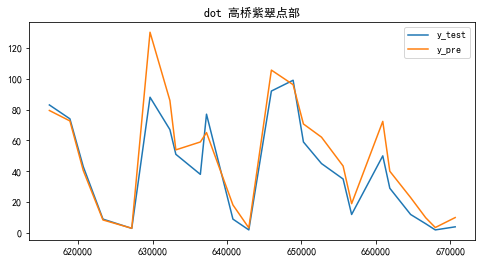

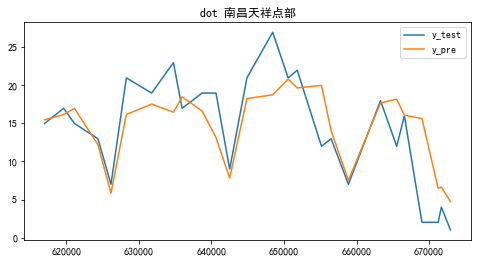

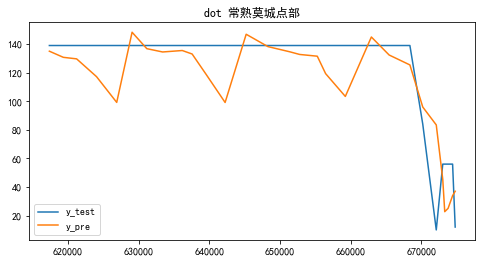

In [69]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 2411, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].unique()[i]), figsize = (8,4))

In [109]:
def pre_feature(data, dot_name):
    x_test_tmp = pd.DataFrame()
    rolling_tmp = pd.DataFrame()
    for dot in dot_name:
        # lagging
        dot_test = data.loc[data['dot'] == dot]
        dot_test_ts = dot_test.copy()
        dot_test['lagging7'] = dot_test['lagging6']
        dot_test['lagging6'] = dot_test['lagging5']
        dot_test['lagging5'] = dot_test['lagging4']
        dot_test['lagging4'] = dot_test['lagging3']
        dot_test['lagging3'] = dot_test['lagging2']
        dot_test['lagging2'] = dot_test['lagging1']
        dot_test['lagging1'] = dot_test['order_num']

        x_test_tmp = pd.concat([x_test_tmp, dot_test])

        # rolling
        dot_test_ts.index = pd.to_datetime(dot_test_ts['order_date'])
        num_ts = dot_test_ts.loc[dot_test_ts['dot'] == dot, ['order_num']]
        rolling = pd.concat([num_ts.rolling(window = 3).mean(), num_ts.rolling(window = 5).mean(), num_ts.rolling(window = 7).mean()], axis = 1)
    #     rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling_tmp = pd.concat([rolling_tmp, rolling])

    x_test = pd.merge(x_test_tmp.drop(['rolling3', 'rolling5', 'rolling7'], axis = 1), rolling_tmp, how = 'left', on = ['dot', 'order_date'])
    x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = 1)
    x_test.dropna(axis = 0, inplace = True)
    
    return x_test

In [110]:
pre_date = dot_train['order_date'].max() + pd.DateOffset(months = -1)
org_test = dot_train[dot_train['order_date'] > pre_date]
test_dot = org_test['dot'].unique()
print("START : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
x_test = pre_feature(org_test, all_dot)
print("END : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# x_test.head()

START :  2019-02-27 11:42:24
END :  2019-02-27 11:49:47


In [115]:
test_dot = org_test['dot'].unique()

In [116]:
x_test = pre_feature(org_test, test_dot)

In [126]:
len(x_test['dot'].unique())

2293

In [123]:
feature_date = dot_train.columns.drop(['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays'])
last_train_date = dot_train['order_date'].max() + pd.DateOffset(days = 1)
x_test_day = x_test.loc[x_test['order_date'] == last_train_date, feature_date]

In [129]:
feature_num = dot_res.columns.drop(['order_num'])
feature = dot_res.columns
x_test_day = time_feature(x_test_day)
x_test_day = x_test_day[feature_num]

In [131]:
y_pre = gbm.predict(x_test_day.drop(['dot', 'order_date'], axis=1))
result = pd.DataFrame({'dot':x_test_day['dot'], 'order_date': x_test_day['order_date'], 'order_num': y_pre})
# result_to_csv = pd.concat([result_to_csv, result])

In [139]:
len(x_test_day)

2217

In [150]:
x_test_merge[x_test_merge['dot'] == '南汇宣桥点部'].head(2)

,dot,city_code,order_date,dot_id,year,month,day,dayofweek,dayofyear,weekofyear,...,湖北省,湖南省,甘肃省,福建省,贵州省,辽宁省,重庆,陕西省,黑龙江省,order_num
0,南汇宣桥点部,21,2019-01-09,330.0,2019,1,9,2,9,2,...,0,0,0,0,0,0,0,0,0,4.446571


In [152]:
org_test[org_test['dot'] == '南汇宣桥点部'].tail(2)

,dot,city_code,order_date,order_num,dot_id,year,month,day,dayofweek,dayofyear,...,海南省,湖北省,湖南省,甘肃省,福建省,贵州省,辽宁省,重庆,陕西省,黑龙江省
611366,南汇宣桥点部,21,2019-01-07,4.304065,330.0,2019,1,7,0,7,...,0,0,0,0,0,0,0,0,0,0
614297,南汇宣桥点部,21,2019-01-08,4.276666,330.0,2019,1,8,1,8,...,0,0,0,0,0,0,0,0,0,0


In [153]:
x_test[x_test['dot'] == '南汇宣桥点部'].tail(2)

,dot,city_code,order_date,order_num,dot_id,year,month,day,dayofweek,dayofyear,...,甘肃省,福建省,贵州省,辽宁省,重庆,陕西省,黑龙江省,rolling3,rolling5,rolling7
29,南汇宣桥点部,21,2019-01-08,4.304065,330.0,2019,1,7,0,7,...,0,0,0,0,0,0,0,4.059855,4.339602,4.158077
30,南汇宣桥点部,21,2019-01-09,4.276666,330.0,2019,1,8,1,8,...,0,0,0,0,0,0,0,4.143626,4.212404,4.309190
